# 데이터 로드

In [29]:
import pandas as pd
import numpy as np

EEG_data = []
Labels = []

for i in range(22):
    try:
        file_path = f"_DATA/eeg_data/{i+1:02}_thinking.csv"
        data = pd.read_csv(file_path)
        
        grouped = data.groupby('Epoch')
        
        subject_EEG = []
        subject_Labels = []
        for name, group in grouped:
            EEG_signals = group.iloc[:, 2:16].values
            label = group.iloc[0, 16]
            subject_EEG.append(EEG_signals)
            subject_Labels.append(label)
        
        EEG_data.append(np.array(subject_EEG))
        Labels.append(np.array(subject_Labels))

    except FileNotFoundError:
        print(f"{i+1:02} 번 파일이 존재하지 않습니다.")
        continue

all_EEG_data = np.vstack(EEG_data)
all_Labels = np.hstack(Labels)


05 번 파일이 존재하지 않습니다.
12 번 파일이 존재하지 않습니다.
22 번 파일이 존재하지 않습니다.


In [30]:
np.save('_NPY/ori_EEG_data.npy', all_EEG_data)
np.save('_NPY/ori_Label.npy', all_Labels)

# 데이터 전처리

In [31]:
all_EEG_data = np.load('_NPY/ori_EEG_data.npy')
all_Labels = np.load('_NPY/ori_Labels.npy')

## Band Pass Filter

In [32]:
# Band Pass Filter (4~30)
from scipy.signal import butter, sosfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def apply_bandpass_filter(data, sos):
    filtered = sosfilt(sos, data, axis=0)
    return filtered

fs = 256
sos = butter_bandpass(4, 30, fs, order=5)

filtered_EEG_data = [apply_bandpass_filter(eeg, sos) for eeg in all_EEG_data if eeg.size > 0]

filtered_EEG_array = np.stack(filtered_EEG_data)

print(filtered_EEG_data[0][0])

print("Original EEG_data shape:", all_EEG_data.shape)
print("Filtered EEG_data shape:", filtered_EEG_array.shape)


[5.80547978 5.80319579 5.82919344 5.84781327 5.81654585 5.82322121
 5.78773836 5.81338411 5.80600629 5.84254349 5.83024713 5.78440068
 5.81197853 5.8585281 ]
Original EEG_data shape: (3040, 1280, 14)
Filtered EEG_data shape: (3040, 1280, 14)


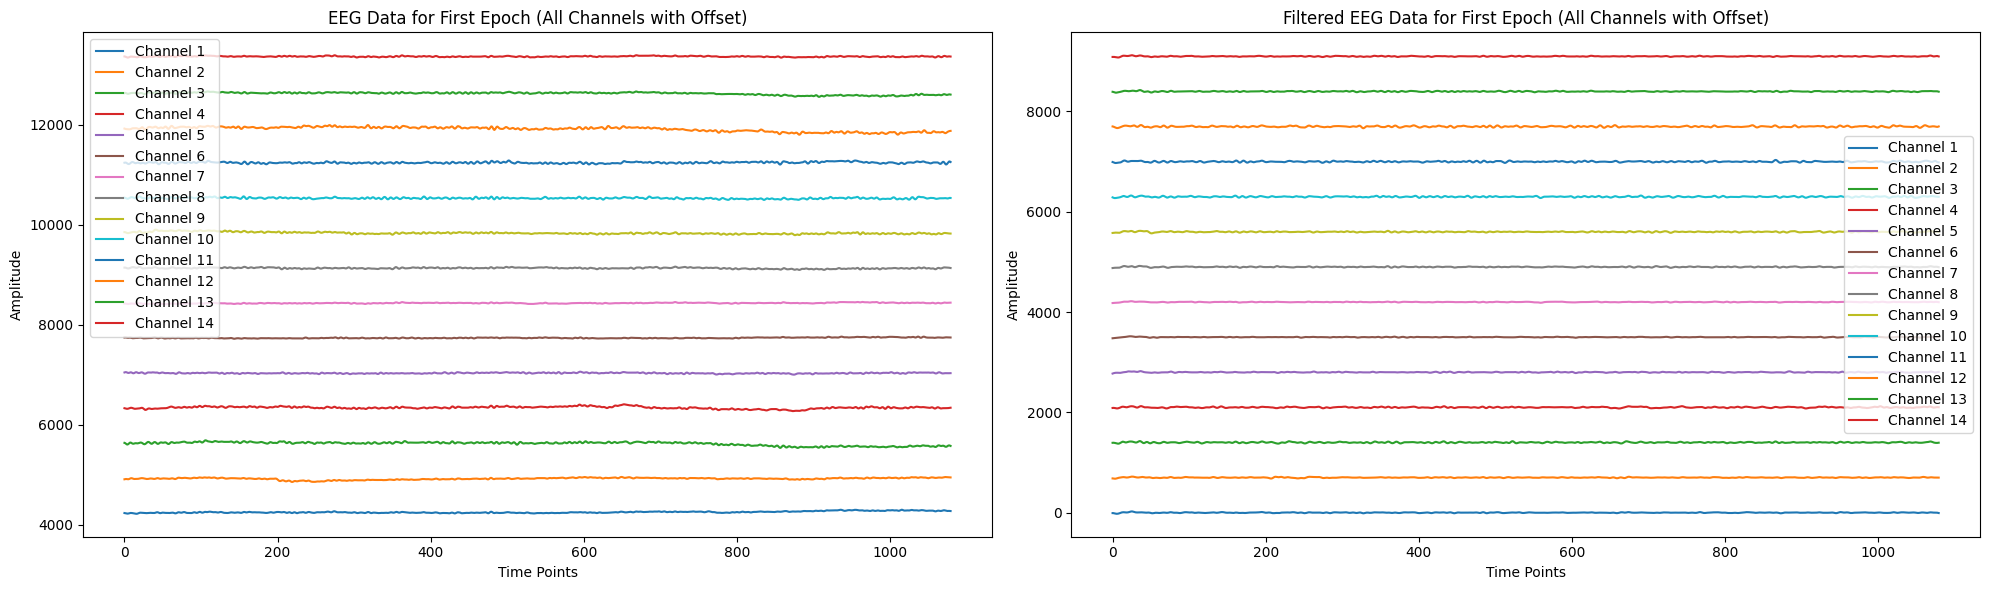

In [34]:
import matplotlib.pyplot as plt

first_epoch_data = all_EEG_data[0, 200:, :]

first_epoch_filtered = filtered_EEG_array[0, 200:, :]

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.title('EEG Data for First Epoch (All Channels with Offset)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')

for channel in range(first_epoch_data.shape[1]):
    plt.plot(first_epoch_data[:, channel] + channel * 700, label=f'Channel {channel + 1}')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Filtered EEG Data for First Epoch (All Channels with Offset)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')

for channel in range(first_epoch_filtered.shape[1]):
    plt.plot(first_epoch_filtered[:, channel] + channel * 700, label=f'Channel {channel + 1}')
plt.legend()

plt.tight_layout()
plt.show()


## CAR

In [35]:
#filtered_EEG_array = filtered_EEG_array[:, 200:, :]

In [36]:
# CAR
common_mode = np.mean(filtered_EEG_array, axis=2, keepdims=True)

CAR_EEG_data = filtered_EEG_array - common_mode

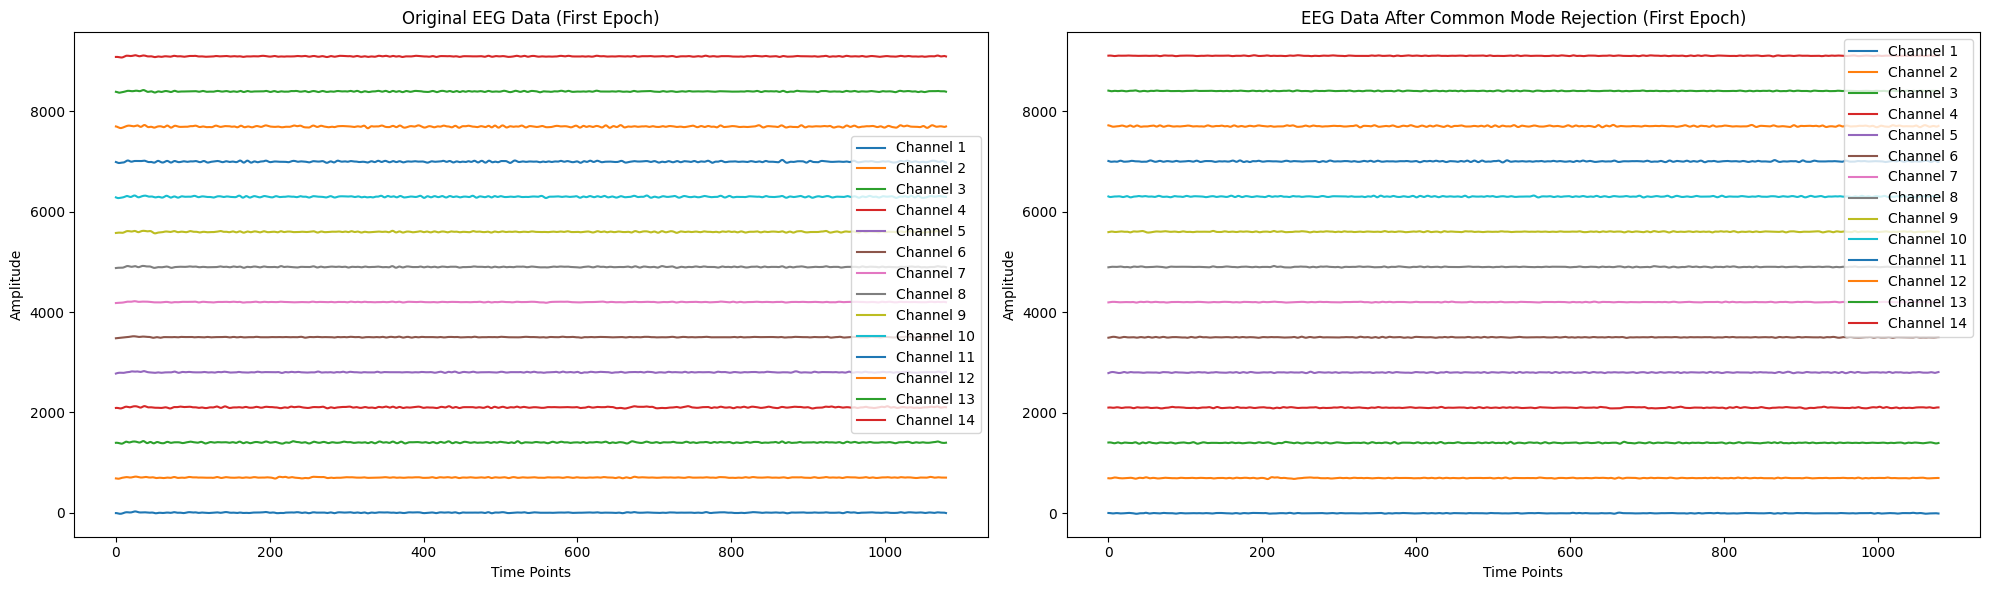

In [37]:
first_epoch_filtered = filtered_EEG_array[0, :, :]
first_epoch_car = CAR_EEG_data[0, :, :]

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.title('Original EEG Data (First Epoch)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
for channel in range(first_epoch_filtered.shape[1]):
    plt.plot(first_epoch_filtered[:, channel] + channel * 700, label=f'Channel {channel + 1}')

plt.legend()

plt.subplot(1, 2, 2)
plt.title('EEG Data After Common Mode Rejection (First Epoch)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
for channel in range(first_epoch_car.shape[1]):
    plt.plot(first_epoch_car[:, channel] + channel * 700, label=f'Channel {channel + 1}')

plt.legend()
plt.tight_layout()
plt.show()

In [38]:
np.save('_NPY/200_BPF_EEG_data.npy', filtered_EEG_array)
np.save('_NPY/200_CAR_EEG_data.npy', CAR_EEG_data)

# EpochsArray 객체 생성

## 라벨 정수화

In [59]:
unique_labels = np.unique(all_Labels)
label_to_int = {label: i for i, label in enumerate(unique_labels)}

int_labels = np.array([label_to_int[label] for label in all_Labels])

events = np.column_stack((np.arange(len(all_Labels)), np.zeros(len(all_Labels), dtype=int), int_labels))

print("Label to integer mapping:")
for label, integer in label_to_int.items():
    print(f"{label}: {integer}")

print("Integer labels:", int_labels)
print("Events array shape:", events.shape)



Label to integer mapping:
f: 0
fleece: 1
goose: 2
k: 3
m: 4
n: 5
ng: 6
p: 7
s: 8
sh: 9
t: 10
thought: 11
trap: 12
v: 13
z: 14
zh: 15
Integer labels: [ 2 11 15 ... 10  9  8]
Events array shape: (3040, 3)


## 객체 생성

In [40]:
import mne

channel_names = ['F3', 'FC5', 'AF3', 'F7', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F8', 'AF4', 'FC6', 'F4']
channel_types = ['eeg'] * 14
sfreq = 256 

info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types=channel_types)

# (trials, channels, times)
data = CAR_EEG_data.transpose(0, 2, 1)

events = np.column_stack((np.arange(len(all_Labels)), np.zeros(len(all_Labels), dtype=int), int_labels))

epochs = mne.EpochsArray(data, info, events=events, tmin=0)
print(epochs)


Not setting metadata
3040 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray |  3040 events (all good), 0 – 4.21484 s, baseline off, ~350.7 MB, data loaded,
 '0': 190
 '1': 190
 '2': 190
 '3': 190
 '4': 190
 '5': 190
 '6': 190
 '7': 190
 '8': 190
 '9': 190
 and 6 more events ...>


In [46]:
from mne.preprocessing import ICA

ica = ICA(n_components=0.95, random_state=97, method='fastica')

ica.fit(epochs)

montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

print(epochs.info)

Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\wooyo\AppData\Local\Temp\ipykernel_26860\3598943353.py:5: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs)


Selecting by explained variance: 9 components
Fitting ICA took 29.8s.
<Info | 8 non-empty values
 bads: []
 ch_names: F3, FC5, AF3, F7, T7, P7, O1, O2, P8, T8, F8, AF4, FC6, F4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 256.0 Hz
>


In [47]:
print("Data channel names:", epochs.ch_names)
print("Montage channel names:", montage.ch_names)

print("Channel positions after setting montage:", epochs.get_montage().get_positions())

Data channel names: ['F3', 'FC5', 'AF3', 'F7', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F8', 'AF4', 'FC6', 'F4']
Montage channel names: ['Fp1', 'Fpz', 'Fp2', 'AF9', 'AF7', 'AF5', 'AF3', 'AF1', 'AFz', 'AF2', 'AF4', 'AF6', 'AF8', 'AF10', 'F9', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'F10', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO9', 'PO7', 'PO5', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO6', 'PO8', 'PO10', 'O1', 'Oz', 'O2', 'O9', 'Iz', 'O10', 'T3', 'T5', 'T4', 'T6', 'M1', 'M2', 'A1', 'A2']
Channel positions after setting montage: {'ch_pos': OrderedDict([('F3', array([-0.05180905,  0.0866879 ,  0.07871409])), ('FC5', array([-0.07890598,  0.05136739,  0.06296235])), ('AF3', array([-0.03518601,  0.10912957,  0.05643921])), ('F7', array(

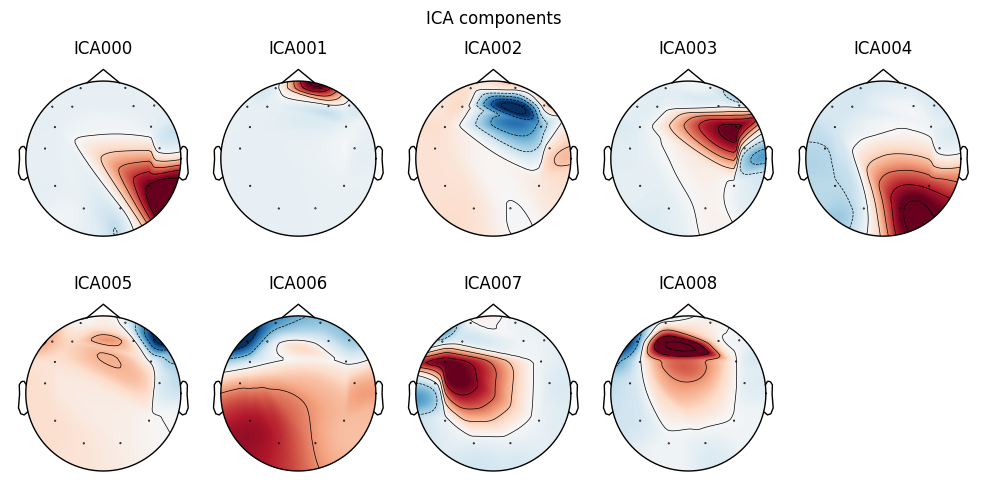

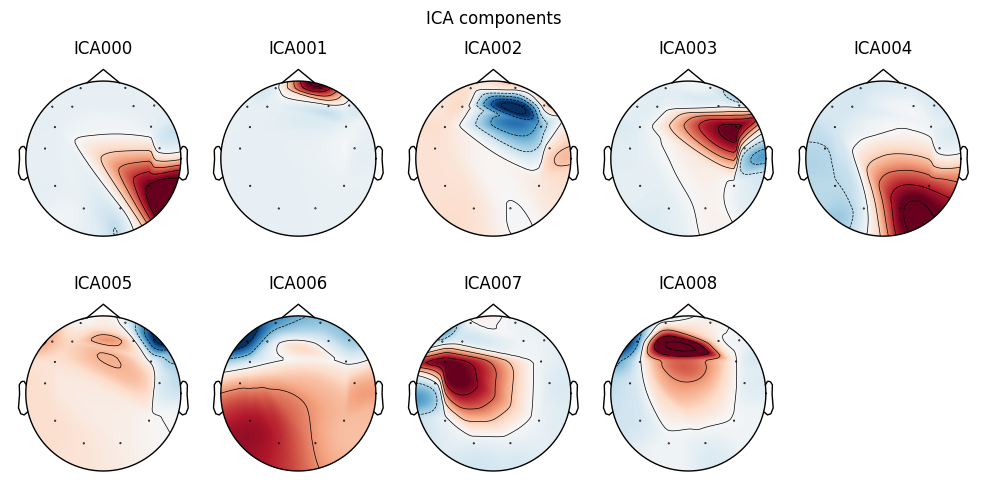

In [48]:
ica.plot_components()

In [49]:
for i in range(ica.n_components_):
    fig = ica.plot_properties(epochs, picks=[i], show=False)
    fig[0].savefig(f'fIG/200_ICA_Component_{i}.png')
    plt.close(fig[0])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3040 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3040 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3040 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3040 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3040 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
3040 matching events found
No baseline correction applied
0 projection it

In [65]:
ica.exclude = [1, 8]

cleaned_epochs = ica.apply(epochs.copy())

Applying ICA to Epochs instance
    Transforming to ICA space (9 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components


# 특징 추출

## CSP

In [68]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import numpy as np


channel_variances = np.var(data, axis=(0, 2))
print("채널 분산:", channel_variances)

# 분산이 평균보다 현저히 낮은 채널 식별
low_variance_channels = np.where(channel_variances < (0.01 * np.mean(channel_variances)))[0]
print("분산이 낮은 채널:", low_variance_channels)

# 분산이 낮은 채널이 있으면 제거
if low_variance_channels.size > 0:
    data = np.delete(data, low_variance_channels, axis=1)
    print("업데이트된 데이터 형태:", data.shape)

# 업데이트된 데이터로 CSP 다시 시도
try:
    csp = CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False, rank='full')
    csp_data = csp.fit_transform(data, int_labels)
    print("CSP 적용 성공.")
except Exception as e:
    print("CSP 적용 실패:", str(e))


채널 분산: [ 144.45216038  174.0678133   106.89719475  148.93564769  110.21527062
  127.94370706  113.90217369  171.15830763 2888.82230021  113.96954508
  208.49539692 1085.43529642  460.38537669  604.96806608]
분산이 낮은 채널: []
Computing rank from data with rank='full'
    MAG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank='full'
    MAG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank='full'
    MAG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank='full'
    MAG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank='full'
    MAG: rank 14 from info
Reducing data rank from 14 -> 14
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank='ful

C:\Users\wooyo\AppData\Local\Temp\ipykernel_26860\996209923.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


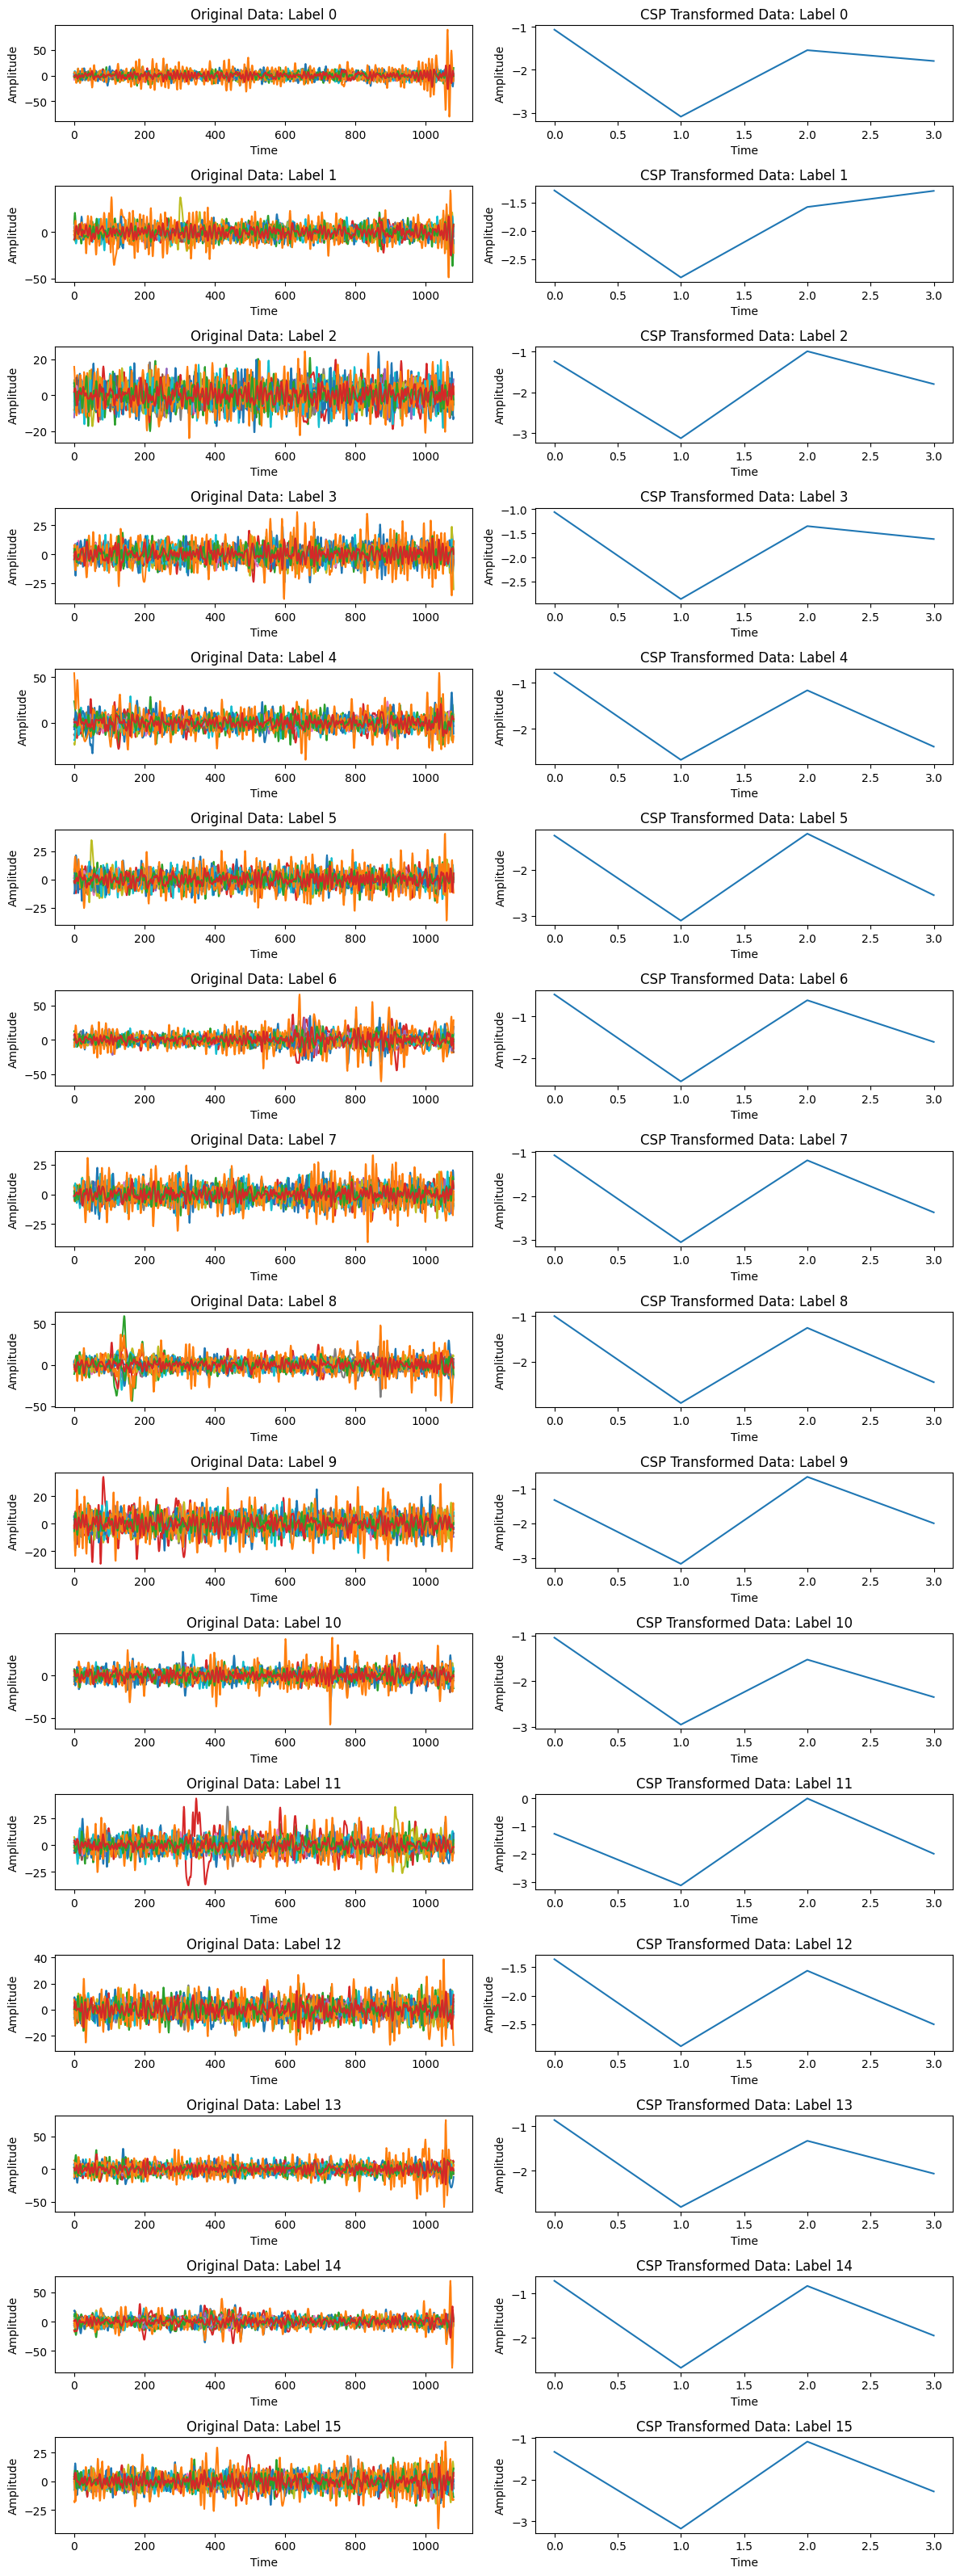

In [69]:
import matplotlib.pyplot as plt
import numpy as np

data = epochs.get_data()

unique_labels = np.unique(int_labels)
label_indices = {label: np.where(int_labels == label)[0][0] for label in unique_labels}

print(unique_labels)

fig, axes = plt.subplots(len(unique_labels), 2, figsize=(12, 2 * len(unique_labels)))  # 2 columns for before and after CSP

for idx, label in enumerate(sorted(unique_labels)):
    example_index = label_indices[label]
    
    # 원본 데이터
    axes[idx, 0].plot(data[example_index].T)
    axes[idx, 0].set_title(f'Original Data: Label {label}')
    axes[idx, 0].set_xlabel('Time')
    axes[idx, 0].set_ylabel('Amplitude')
    
    # CSP 적용된 데이터
    axes[idx, 1].plot(csp_data[example_index].T)
    axes[idx, 1].set_title(f'CSP Transformed Data: Label {label}')
    axes[idx, 1].set_xlabel('Time')
    axes[idx, 1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [65]:
np.save('_NPY/ori_Epoch_data.npy', data)
np.save('_NPY/CSP_Feature_data.npy', csp_data)
np.save('_NPY/CSP_Filter.npy', csp.filters_)
np.save('_NPY/int_labels', int_labels)

# 모델 학습

## SVM

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(csp_data, int_labels, test_size=0.2, random_state=42)

In [71]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링
    ('svc', SVC(kernel='linear', random_state=42))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(kernel='linear', random_state=42))])

In [72]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.03125
